Лабораторная работа №7,вариант №4

***Задание:*** Решить краевую задачу для *дифференциального уравнения эллиптического типа*. Аппроксимацию уравнения произвести с использованием *центрально-разностной схемы*. Для решения дискретного аналога применить следующие методы: *метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией*. В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением u(x, t). Исследовать зависимость погрешности от сеточных параметров tau и h.

In [1]:
import random
import matplotlib.pyplot as plt
import sys
import warnings
import numpy as np
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#Граничные условия
def psi_0(x):
    return np.sin(x)

def psi_1(x):
    return np.sin(x) * np.e

def phi_0(y):
    return np.exp(y)

def phi_1(y):
    return -np.exp(y)

#Истинное решение
def u(x, y):
    return np.exp(y)*np.sin(x)

In [3]:
class Schema:
    def __init__(self, psi0 = psi_0, psi1 = psi_1, phi0 = phi_0, phi1 = phi_1, lx0 = 0,
                 lx1 = np.pi, ly0 = 0, ly1 = 1, solver="zeidel_method", relax=0.1, epsilon = 0.01):
        self.psi1 = psi1
        self.psi0 = psi0
        self.phi0 = phi0
        self.phi1 = phi1
        self.lx0 = lx0
        self.ly0 = ly0
        self.lx1 = lx1
        self.ly1 = ly1
        self.eps = epsilon
        self.method = None
        if solver == "zeidel_method":
            self.method = self.zeidel_step
        elif solver == "simple_iterations_method":
            self.method = self.simple_eiler_step
        elif solver == "simple_iterations_relaxation_method":
            self.method = lambda x, y, m: self.relaxation_step(x, y, m, relax)
        else:
            raise ValueError("Wrong solver name")
        
    # зейдель  
    def zeidel_step(self, X, Y, M):
      return self.relaxation_step(X, Y, M, w=1)


    # релаксация
    def relaxation_step(self, X, Y, M, w):
      norm = 0.0
      hx2 = self.hx * self.hx
      hy2 = self.hy * self.hy

      for i in range(1, self.Ny - 1):
          dif = w * ((-2 * self.hx * self.phi0(Y[i][0]) + 4 * M[i][1] - M[i][2]) / 3 - M[i][0])
          M[i][0] += dif
          dif = abs(dif)
          norm = dif if dif > norm else norm
          for j in range(1, self.Nx - 1):
              dif = hy2 * (M[i][j - 1] + M[i][j + 1])
              dif += hx2 * (M[i - 1][j] + M[i + 1][j])
              dif /= 2 * (hy2 + hx2)
              dif -= M[i][j]
              dif *= w
              M[i][j] += dif
              dif = abs(dif)
              norm = dif if dif > norm else norm
          dif = w * ((2 * self.hx * self.phi1(Y[i][-1]) + 4 * M[i][-2] - M[i][-3]) / 3 - M[i][-1])
          M[i][-1] += dif
          dif = abs(dif)
          norm = dif if dif > norm else norm

      return norm


    # простые итерации
    def simple_eiler_step(self, X, Y, M):
        temp = [[0.0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        norm = 0.0
        hx2 = self.hx * self.hx
        hy2 = self.hy * self.hy

        for i in range(1, self.Ny - 1):
            temp[i][0] = (-2 * self.hx * self.phi0(Y[i][0]) + 4 * M[i][1] - M[i][2]) / 3
            dif = abs(temp[i][0] - M[i][0])
            norm = dif if dif > norm else norm
            for j in range(1, self.Nx - 1):
                temp[i][j] = hy2 * (M[i][j - 1] + M[i][j + 1])
                temp[i][j] += hx2 * (M[i - 1][j] + M[i + 1][j])
                temp[i][j] /= 2 * (hy2 + hx2)
                dif = abs(temp[i][j] - M[i][j])
                norm = dif if dif > norm else norm
            temp[i][-1] = (2 * self.hx * self.phi1(Y[i][-1]) + 4 * M[i][-2] - M[i][-3]) / 3
            dif = abs(temp[i][0] - M[i][0])
            norm = dif if dif > norm else norm

        for i in range(1, self.Ny - 1):
            M[i] = temp[i]

        return norm
        

    def set_l0_l1(self, lx0, lx1, ly0, ly1):
        self.lx0 = lx0
        self.lx1 = lx1
        self.ly0 = ly0
        self.ly1 = ly1
        
        
    def _compute_h(self):
        self.hx = (self.lx1 - self.lx0) / (self.Nx - 1)
        self.hy = (self.ly1 - self.ly0) / (self.Ny - 1)
    
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
            
    def init_values(self, X, Y):
        ans = [[0 for _ in range(self.Nx)] for _ in range(self.Ny)]
        for j in range(self.Nx):
            coeff = (self.psi1(X[-1][j]) - self.psi0(X[0][j])) / (self.ly1 - self.ly0)
            addition = self.psi0(X[0][j])
            for i in range(self.Ny):
                ans[i][j] = coeff*(Y[i][j] - self.ly0) + addition
        return ans

    
    def __call__(self, Nx=10, Ny=10):
        self.Nx, self.Ny = Nx, Ny
        self._compute_h()
        x = list(self.nparange(self.lx0, self.lx1, self.hx))
        y = list(self.nparange(self.ly0, self.ly1, self.hy))
        X = [x for _ in range(self.Ny)]
        Y = [[y[i] for _ in x] for i in range(self.Ny)]
        ans = self.init_values(X, Y)
        
        self.itters = 0
        
        while(self.method(X, Y, ans) >= self.eps):
            self.itters += 1
        
        return X, Y, ans

#### Сетка для истинной функции

In [4]:
def real_z(lx0, lx1, ly0, ly1, f):
    x = np.arange(lx0, lx1 + 0.005, 0.005)
    y = np.arange(ly0, ly1 + 0.005, 0.005)
    X = np.ones((y.shape[0], x.shape[0]))
    Y = np.ones((x.shape[0], y.shape[0]))
    Z = np.ones((y.shape[0], x.shape[0]))
    for i in range(Y.shape[0]):
        Y[i] = y
    Y = Y.T
    for i in range(X.shape[0]):
        X[i] = x
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = f(X[i, j], Y[i, j])
    return X, Y, Z

In [5]:
def All_plot(Nx=10, Ny=10, eps=0.001, met="simple_iterations_relaxation_method"):
    schema = Schema(epsilon=eps, solver=met)
    x, y, z = schema(Nx, Ny)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_wireframe(*real_z(0, np.pi, 0, 1, u), color="blue")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='y', zlabel='z', 
           title=f'График решения и реальной функции методом {met}')
    fig.tight_layout()
    plt.show()

/usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


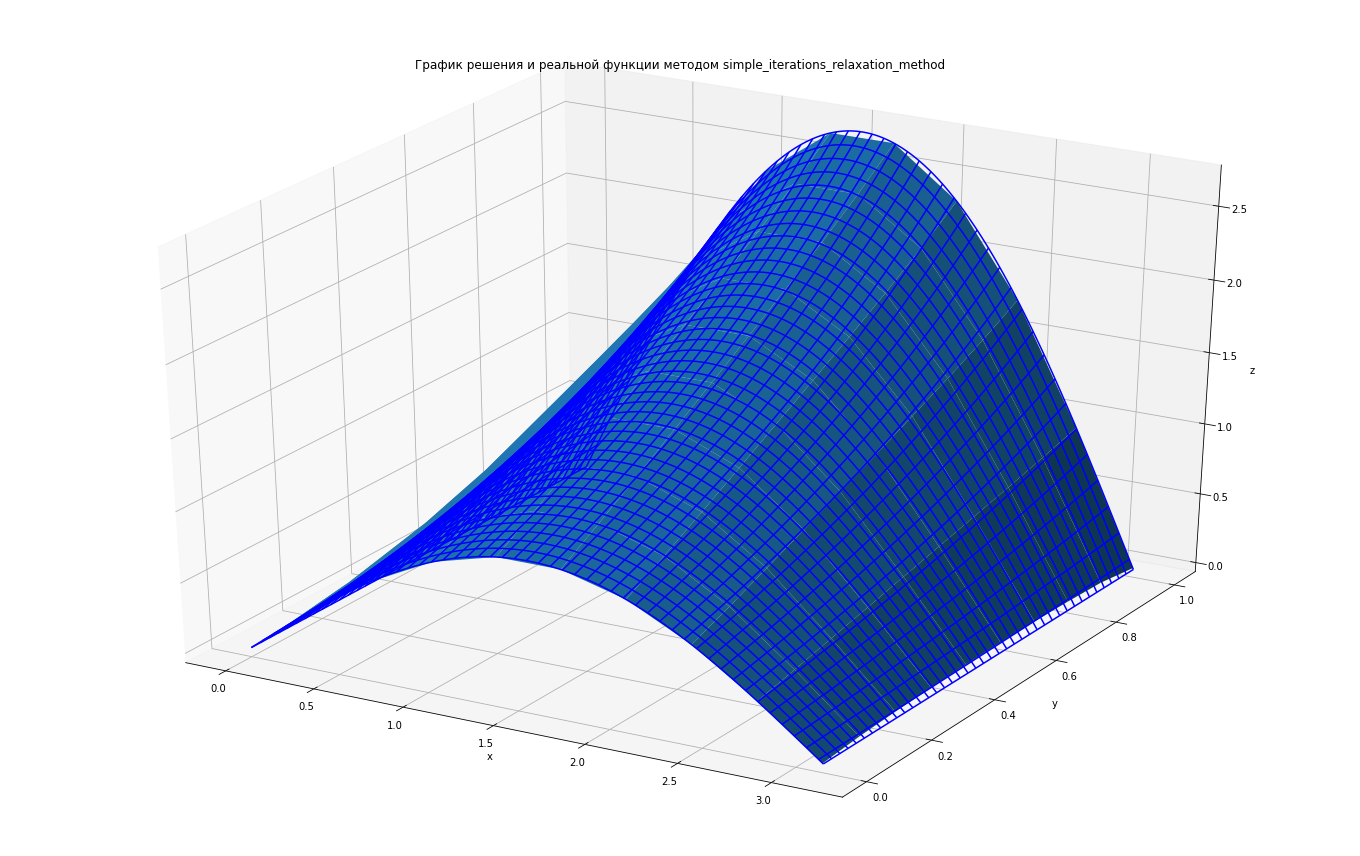

In [6]:
#Метод релаксации
All_plot()
None

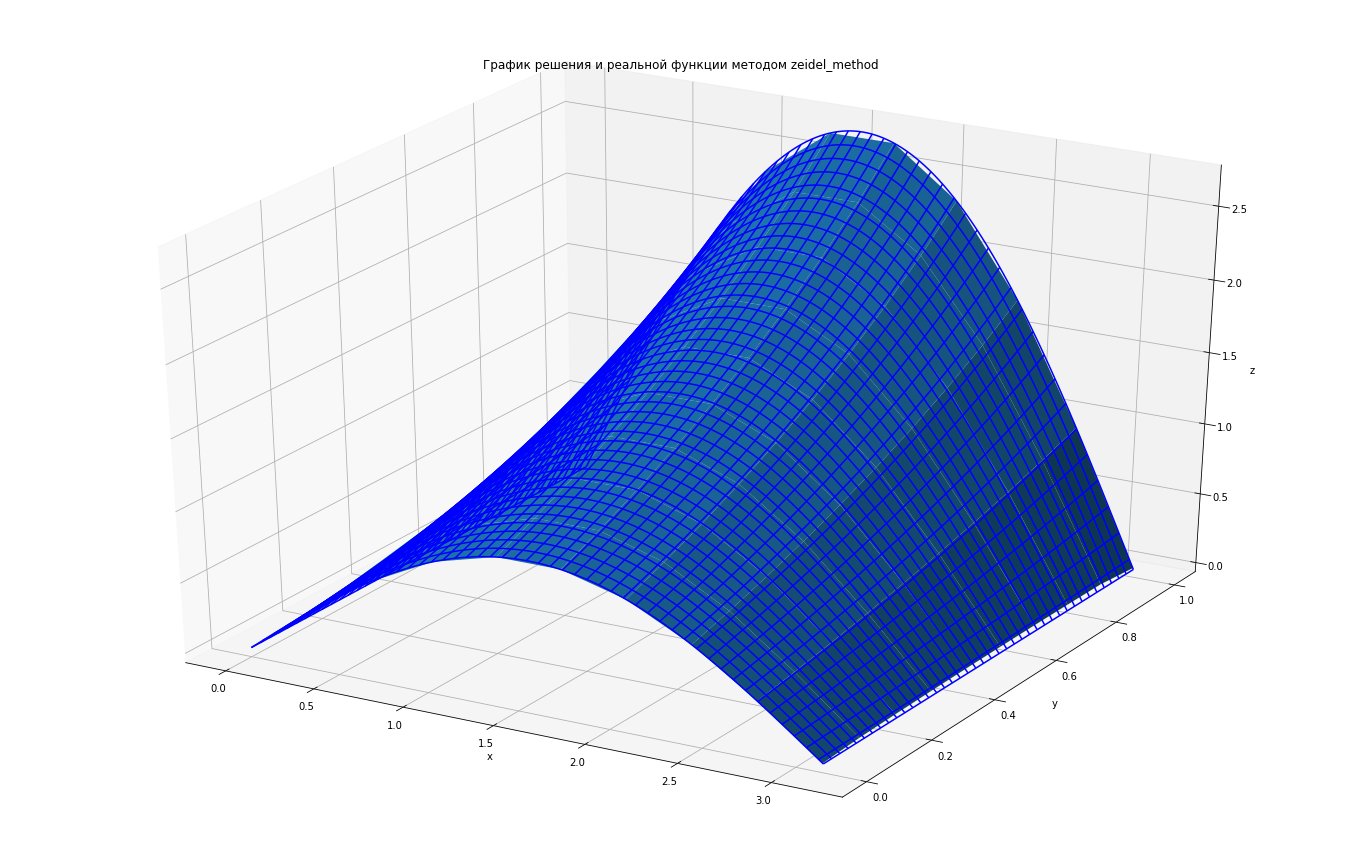

In [7]:
#Метод Зейделя
All_plot(met="zeidel_method")
None

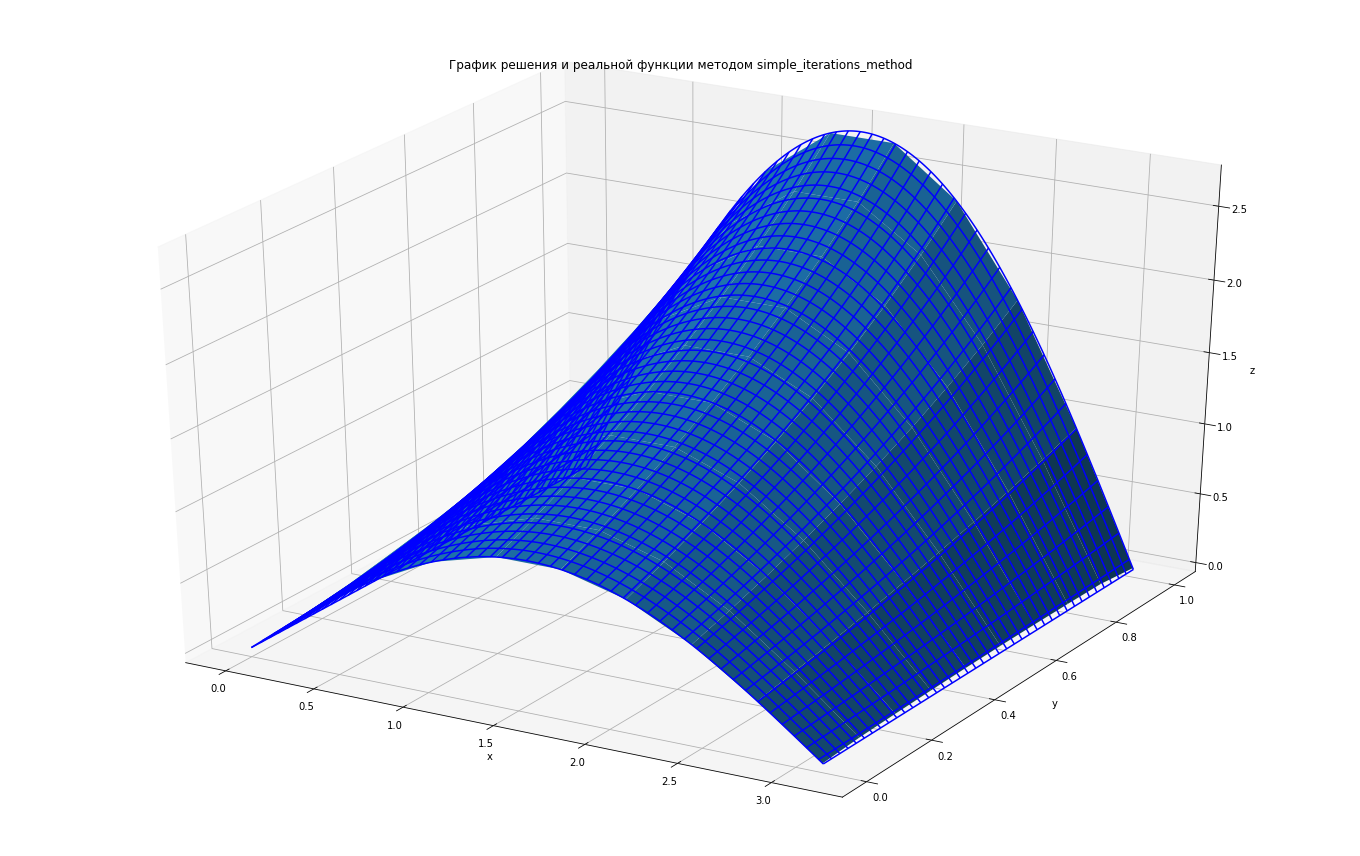

In [8]:
#Метод простых итераций
All_plot(met="simple_iterations_method")
None

#### Сходимость методов

In [9]:
schema = Schema(epsilon=0.001, solver="simple_iterations_method")
schema(10, 10)
print("Количество итераций метода простых иттераций:", schema.itters)

Количество итераций метода простых иттераций: 41


In [10]:
schema = Schema(epsilon=0.001, solver='zeidel_method')
schema(10, 10)
print("Количество иттераций метода Зейделя:", schema.itters)

Количество иттераций метода Зейделя: 27


In [11]:
schema = Schema(epsilon=0.001, solver='simple_iterations_relaxation_method', relax=1.5)
schema(10, 10)
print("Количество итераций метода простых итераций с релаксацией:", schema.itters)

Количество итераций метода простых итераций с релаксацией: 13


Зависимость погрешности от параметра h

In [12]:
def epsilon(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            ans += (z[i][j] - f(x[i][j], y[i][j]))**2
    return (ans / (len(z) * len(z[0])))**0.5

In [13]:
def graphic_h(solver, real_f):
    h = []
    e = []
    for N in range(4, 80, 3):
        x, y, z = solver(N, N)
        h.append(solver.hx)
        e.append(epsilon(x, y, z, real_f))
        
    return h, e

In [14]:
explict = Schema(epsilon=0.00001)

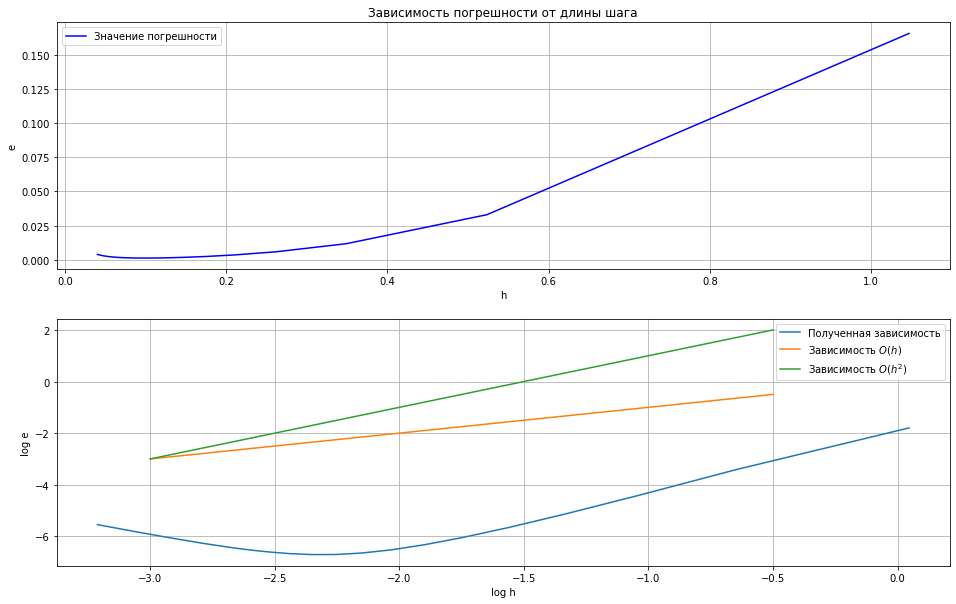

In [15]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = graphic_h(explict, u)

plt.plot(h, e, label="Значение погрешности", color = "blue")
plt.xlabel("h")
plt.ylabel("e")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#В логарифмической шкале
plt.plot(list(map(np.log, h)), list(map(np.log, e)), label="Полученная зависимость")
plt.plot([-3, -0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-3, -0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.legend()
plt.grid()